In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [2]:
# This converter function will convert the string into corresponding value.
#def converter1(x):
#    if x == b'A' or x == b'B' or x == b'C' or x == b'D' or x == b'E' or x == b'F' or x == b'G' or x == b'H' or x == b'I' or x == b'J' or x == b'K' or x == b'L' or x == b'M':       
#        return 1
#    else:
#        return 0
def converter1(x):
    if ord(x)-ord(b'M') > 0:
        return 0
    else:
        return 1

In [3]:
column1 = 0

data = np.loadtxt('letter-recognition.data', delimiter=',', 
               converters={column1:converter1})

In [4]:
print(data)
print(data.shape)

[[  0.   2.   8. ...,   8.   0.   8.]
 [  1.   5.  12. ...,   8.   4.  10.]
 [  1.   4.  11. ...,   7.   3.   9.]
 ..., 
 [  0.   6.   9. ...,  12.   2.   4.]
 [  0.   2.   3. ...,   9.   5.   8.]
 [  1.   4.   9. ...,   7.   2.   8.]]
(20000, 17)


In [5]:
# Divide data into training and testing sets
X_and_Y = data
np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
X = X_and_Y[:5000,1:17]
Y = X_and_Y[:5000,0]
print(X.shape, Y.shape)

(5000, 16) (5000,)


In [6]:
X_train_val = X[:int(0.2*len(X))]
X_test      = X[int(0.2*len(X)):]
Y_train_val = Y[:int(0.2*len(Y))]
Y_test      = Y[int(0.2*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(1000, 16) (4000, 16) (1000,) (4000,)


In [7]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  2.38209724e-02,   2.44163513e-02,   2.27162361e-02,
          2.32162952e-02,   2.44171143e-02,   2.35166550e-02,
          3.95280361e-02,   1.34094477e-01,   1.11198606e+00,
          9.41958208e+00,   8.58891538e+01]),
 'mean_score_time': array([ 0.00450058,  0.00440302,  0.00410285,  0.00380244,  0.00410323,
         0.00440345,  0.00320215,  0.00320268,  0.00260162,  0.00280499,
         0.00260191]),
 'mean_test_score': array([ 0.523,  0.523,  0.523,  0.595,  0.676,  0.69 ,  0.692,  0.694,
         0.691,  0.692,  0.693]),
 'mean_train_score': array([ 0.52300003,  0.52300003,  0.52300003,  0.60100762,  0.68425179,
         0.70125025,  0.71074777,  0.71149839,  0.71224933,  0.71224933,
         0.71249933]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},
  {'C': 1e-

In [8]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0}
0.71725


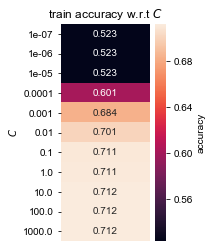

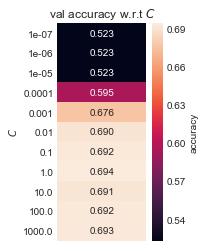

In [9]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [10]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.06054373,  0.06294427,  0.05854158,  0.05263753,  0.04803338,
         0.13999882,  0.09186525,  0.03632531,  0.06045933,  0.05703979,
         0.05063639,  0.05714664,  0.05724039,  0.14480557,  0.0904614 ,
         0.03762584,  0.05213656,  0.0569726 ,  0.06240835,  0.06744733,
         0.0606421 ,  0.13599901,  0.0939724 ,  0.04152894,  0.05884147,
         0.06324987,  0.05033498,  0.05393834,  0.04463139,  0.14571505,
         0.08646717,  0.03682561,  0.06084208,  0.05563951,  0.06654649,
         0.05794082,  0.05914178,  0.13720088,  0.09217706,  0.03882699,
         0.06494503,  0.05393872,  0.06714807,  0.05333757,  0.05784054,
         0.1495049 ,  0.09966989,  0.04042826,  0.07115006,  0.07625327,
         0.0686502 ,  0.0776557 ,  0.08215637,  0.16621923,  0.11257863,
         0.04353614,  0.08286943,  0.07665682,  0.07835565,  0.07815533,
         0.08986335,  0.16961985,  0.12799053,  0.05643969,  0.08445926,
         0.08175697,  0.08966351, 

In [11]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 10.0, 'gamma': 0.125}
0.884


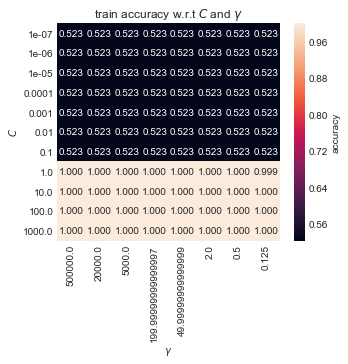

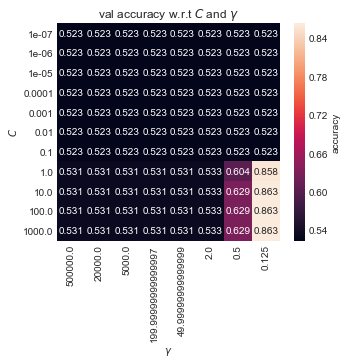

In [12]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [13]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 1.,  1.,  1., ...,  0.,  1.,  1.])

In [14]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.772


In [15]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 1.,  0.,  0., ...,  0.,  1.,  1.])

In [16]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.8865
